In [1]:
import os
import ee
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

import geemap

from geeml.utils import eeprint

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [2]:
import ee
service_account = 'github-action@ee-geethensingh.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, r"C:\Users\coach\myfiles\postdoc\Fire\code\secret.json")
ee.Initialize(credentials)

In [3]:
os.chdir(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src")
os.getcwd()

'C:\\Users\\coach\\myfiles\\postdoc\\Fire\\code\\Burn_Area_Mapping\\src'

In [4]:
from components.data_extraction import extractDataset
%load_ext autoreload


In [13]:
%autoreload 2

In [5]:
Map = geemap.Map()
fc = ee.FeatureCollection("projects/ee-geethensingh/assets/postdoc/proj_fired_south_africa_to2021182_events")
Map.addLayer(ee.Feature(fc.first()), {'color': 'red'}, "Fire Test")
Map.centerObject(fc.first(), 12)
Map

Map(center=[-31.374999751707104, 29.510986261502627], controls=(WidgetControl(options=['position', 'transparen…

## Step 1: Data extraction

In [6]:
# Filter fire events to period and area of interest
fireEvents = fc.map(lambda ft: ft.set('system:time_start', ee.Date(ft.get('ig_date')))
                    .set('system:time_end', ee.Date(ft.get('last_date')))).filterDate('2017-01-01', '2022-01-01')

In [ ]:
# Get Sentinel-2 features for South Africa - error with or before getstats function. returns None values
extractDataset('Sentinel-2', 'South Africa', ee.Date('2021-01-01'), ee.Date('2021-01-02'), fireEvents, 5, 'extract_s2_2021010120220101.csv')
# Get Landsat-8 features for South Africa (24 hrs to extract data for 1 year. 1 day = 9 Landsat images = 4 mins)
# extractDataset('LANDSAT_8', 'South Africa', ee.Date('2020-01-01'), ee.Date('2020-01-02'), fireEvents, 16, 'extract_l8_2013010120220101.csv')

  0%|          | 0/76 [00:00<?, ?it/s]

  temporal_variance_p25 temporal_variance_p5 temporal_variance_p50  \
0                  None                 None                  None   

  temporal_variance_p75 temporal_variance_p95  \
0                  None                  None   

                                              scenes  label  
0  [1_20201230T080239_20201230T082138_T35HLD, 1_2...      0  


KeyboardInterrupt: 

## Step 2: train and evaluation

In [10]:
from data_ingestion import dataIngestion
from data_transformation import dataTransformation
from model_trainer import modelTrainer

ModuleNotFoundError: No module named 'utils'

Naive Baseline Accuracy: 0.74
No best model found, metric < 0.6


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached 'artifacts'
            git commit -m "stop tracking artifacts" 


classification report               precision    recall  f1-score   support

         0.0       0.79      0.93      0.86       206
         1.0       0.59      0.28      0.38        71

    accuracy                           0.77       277
   macro avg       0.69      0.61      0.62       277
weighted avg       0.74      0.77      0.73       277

Confusion Matrix:


0.380952380952381

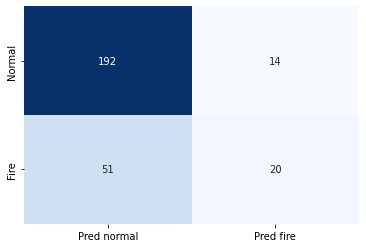

In [8]:
obj = dataIngestion()
train_path, calibration_path, test_path = obj.initiate_data_ingestion()
data_transformation = dataTransformation()
train_arr, cal_arr, test_arr = data_transformation.initiate_data_transformation(train_path, calibration_path, test_path)

model_trainer = modelTrainer()
model_trainer.initiate_model_trainer(train_arr, cal_arr, test_arr)

## Step 3: Inference

In [ ]:
from src.utils import load_object
import pandas as pd

from mapie.classification import MapieClassifier

# model = load_object(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\model.pkl")
df = pd.read_csv(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\train.csv")


X_train = df.drop(['scenes', 'label'], axis=1)
y_train = df[['label']]

# from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state= 42, verbose= False).fit(X_train, y_train)
print(model.predict(dfPredict))

mapie_score = MapieClassifier(estimator = model, cv="prefit", method="lac", random_state= 42)
mapie_score.fit(X_train, y_train)
mapie_score.predict(dfPredict, alpha =0.05)

In [25]:
from inference import Inference

inference_pipeline = Inference()
sceneList = inference_pipeline.initiate_inference_pipeline('LANDSAT_8', 'South Africa')
sceneList

Number of new scenes: 55
input dates 2024-03-01 2024-04-02


  0%|          | 0/55 [00:00<?, ?it/s]

0    2_LC08_160092_20240310
0    2_LC08_167079_20240311
0    2_LC08_167080_20240311
0    2_LC08_168077_20240302
0    2_LC08_168078_20240302
0    2_LC08_168080_20240302
0    2_LC08_168081_20240302
0    2_LC08_168082_20240302
0    2_LC08_169075_20240309
0    2_LC08_169078_20240309
0    2_LC08_169079_20240309
0    2_LC08_169080_20240309
0    2_LC08_169082_20240309
0    2_LC08_171076_20240307
0    2_LC08_171078_20240307
0    2_LC08_171079_20240307
0    2_LC08_171080_20240307
0    2_LC08_171081_20240307
0    2_LC08_171082_20240307
0    2_LC08_173077_20240305
0    2_LC08_173078_20240305
0    2_LC08_173079_20240305
0    2_LC08_173080_20240305
0    2_LC08_173081_20240305
0    2_LC08_173082_20240305
0    2_LC08_175077_20240303
0    2_LC08_175078_20240303
0    2_LC08_175082_20240303
0    2_LC08_176077_20240310
0    2_LC08_176078_20240310
0    2_LC08_177081_20240301
Name: scenes, dtype: object

In [43]:
# Example usage:
# Delete logs older than March 1, 2024
delete_old_logs(r'C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping', datetime.datetime(2024, 3, 11))
# Or, delete logs older than one month (default behavior)
delete_old_logs(r'C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping')

Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_06_2024_14_13_35.log\03_06_2024_14_13_35.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_06_2024_23_25_28.log\03_06_2024_23_25_28.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_07_2024_09_11_34.log\03_07_2024_09_11_34.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_07_2024_20_08_47.log\03_07_2024_20_08_47.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_08_2024_09_41_30.log\03_08_2024_09_41_30.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_08_2024_10_15_57.log\03_08_2024_10_15_57.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_08_2024_10_19_03.log\03_08_2024_10_19_03.log
Deleted file:

## Stage 2: Semantic Segmentation

In [2]:
import os
import ee
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

import geemap

from geeml.utils import eeprint


Successfully saved authorization token.


In [3]:
import os
os.getcwd()
os.chdir("C:/Users/coach/myfiles/postdoc/Fire/code/Burn_Area_Mapping")

%load_ext autoreload

In [4]:
os.getcwd()

'C:\\Users\\coach\\myfiles\\postdoc\\Fire\\code\\Burn_Area_Mapping'

In [ ]:
%autoreload 2
from stage_2.inference import segment

# perform inference
segment().main()

In [7]:
supportedSensors = {'Sentinel-1': 'COPERNICUS/S1_GRD',
                    'Sentinel-2': "COPERNICUS/S2_SR_HARMONIZED",
                    'LANDSAT_8': "LANDSAT/LC08/C02/T1_L2",
                    'LANDSAT_9': "LANDSAT/LC09/C02/T1_L2"}

In [7]:
from src.utils import load_object
import pandas as pd

downloadList = pd.read_pickle(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\downloadList.pkl")
downloadList

0    2_LC08_160092_20240310
0    2_LC08_167079_20240311
0    2_LC08_167080_20240311
0    2_LC08_168077_20240302
0    2_LC08_168078_20240302
0    2_LC08_168080_20240302
0    2_LC08_168081_20240302
0    2_LC08_168082_20240302
0    2_LC08_169075_20240309
0    2_LC08_169078_20240309
0    2_LC08_169079_20240309
0    2_LC08_169080_20240309
0    2_LC08_169082_20240309
0    2_LC08_171076_20240307
0    2_LC08_171078_20240307
0    2_LC08_171079_20240307
0    2_LC08_171080_20240307
0    2_LC08_171081_20240307
0    2_LC08_171082_20240307
0    2_LC08_173077_20240305
0    2_LC08_173078_20240305
0    2_LC08_173079_20240305
0    2_LC08_173080_20240305
0    2_LC08_173081_20240305
0    2_LC08_173082_20240305
0    2_LC08_175077_20240303
0    2_LC08_175078_20240303
0    2_LC08_175082_20240303
0    2_LC08_176077_20240310
0    2_LC08_176078_20240310
0    2_LC08_177081_20240301
Name: scenes, dtype: object

In [ ]:
def getImage(sensor: str, pre: bool, event: ee.Feature, dateBuffer: int)->ee.Image:
    """
    Get the temporally closest pre-fire and post-fire optical or radar images after preprocessing both
    the optical images.

    Args:
        event (ee.Feature): A fire event delineating the boundary of burnt area
        dateBuffer (int): The temporal window to locate a relevant image. In units of weeks.

    Returns:
        A pre-fire and post-fire optical or radar image
    """
    # Filter images that intersect the geometry using the optimised filterBounds. Thereafter, use the
    # ee.filter.contains that is not as optimised as filterBounds
    images = supportedSensors.get(sensor).filterBounds(event.geometry())
    eventDate = ee.Date(event.get('Ig_Date'))
    if pre:
        startDate = eventDate.advance(dateBuffer*-1, 'week')
        endDate = eventDate
        outImage = cloudMask1(images.filterDate(startDate, endDate).sort('system:time_start', False)).reduce(ee.Reducer.firstNonNull()).regexpRename('.{6}$','')
        # .filter(ee.Filter.contains('.geo', event.geometry())).sort('system:time_start', False).first()

    else:
        # postfire
        startDate = eventDate
        endDate = eventDate.advance(dateBuffer, 'week')
        outImage = cloudMask2(images.filterDate(startDate, endDate))#.reduce(ee.Reducer.firstNonNull()).regexpRename('.{6}$','')#.qualityMosaic('nbr')
        # .filter(ee.Filter.contains('.geo', event.geometry())).sort('system:time_start', True).first()
    
    return outImage

    # Given a fire event get pre and post fire image from multi-sensors
def getOpticalRadarPairs(sensor:str, dnbr:bool, event: ee.Feature, dateBuffer: int = 4)-> ee.Image:
    """
    Get optical-radar pairs for a given fire event. First image after fire event and image before fire event

    Args:
        sensor(str): The name of the sensor. One of ['Sentinel-1', 'Sentinel-2', 'Landsat_8', 'Landsat_9']
        event(ee.Feature): A fire event
        dateBuffer(int): The temporal-search window. 
    
    Returns:
        An image with optical-radar pairs

    """
    # Post-fire image
    if sensor != 'any':
        postOpticalImage = getImage(sensor, False, event, dateBuffer= dateBuffer)
    else:
        s2post = getImage('Sentinel-2', False, event, dateBuffer= dateBuffer)
        l8post = getImage('LANDSAT_8', False, event, dateBuffer= dateBuffer)
        l9post = getImage('LANDSAT_9', False, event, dateBuffer= dateBuffer)
        # get the earliest optical image (between L8, L9 and S2) that was captured after the fire event
        postOpticalImage = ee.ImageCollection.fromImages([s2post, l8post, l9post]).sort('system:time_start', True).first()
    # pre-process post-fire image
    # postOpticalImage = ee.Image(preprocessOptical(postOpticalImage, sensor).copyProperties(postOpticalImage))

    # if sensor == 'Sentinel-1':
    #     # RADAR
    #     s1post = getImage('Sentinel-1', False, event, dateBuffer= dateBuffer)
    #     # preprocess pre-fire radar image
    #     parameters.update({'STOP_DATE': s1post.date().advance(1, 'day'), 'START_DATE': s1post.date(), 'ROI': event.geometry()})
    #     s1post = wp.s1_preproc(parameters).select('V.')
    
    # pre-fire
    if sensor != 'any':
        # If only one sensor is to be used
        preOpticalImage = getImage(sensor, True, event, dateBuffer= dateBuffer)
    else:
        # If any optical sensor is to be used
        s2pre = getImage('Sentinel-2', True, event, dateBuffer= dateBuffer)
        l8pre = getImage('LANDSAT_8', True, event, dateBuffer= dateBuffer)
        l9pre = getImage('LANDSAT_9', True, event, dateBuffer= dateBuffer)
        # get the earliest optical image (between L8, L9 and S2) that was captured after the fire event
        preOpticalImage = ee.ImageCollection.fromImages([s2pre, l8pre, l9pre]).sort('system:time_start', True).first()
    
    # elif multisensor:
    #     # if multisensor data is to be used, add radar to optical
    #     # RADAR
    #     s1pre = getImage('Sentinel-1', True, event, dateBuffer= dateBuffer)
    #     # preprocess pre-fire radar image
    #     parameters.update({'STOP_DATE': s1pre.date().advance(1, 'day'), 'START_DATE': s1pre.date(), 'ROI': event.geometry()})
    #     s1pre = wp.s1_preproc(parameters).select('V.')

    # pre-process pre-fire image
    # preOpticalImage = ee.Image(preprocessOptical(preOpticalImage, sensor).copyProperties(preOpticalImage))

    if dnbr:
        postOpticalImage = qualityMosaicPercentile(postOpticalImage.map(lambda img: img.addBands(
            preOpticalImage.normalizedDifference(['B8A', 'B12']).subtract(img.normalizedDifference(['B8A', 'B12'])).rename('dnbr'))), 'dnbr', 95) 
    
    return postOpticalImage
    # return preOpticalImage.regexpRename('$', '_pre'), s1pre, postOpticalImage.regexpRename('$', '_post'), s1post
    

LANDSAT/LC08/C02/T1_L2/LC08_175082_20240303


In [40]:
fires = ee.FeatureCollection("projects/ee-geethensingh/assets/postdoc/All_fires_23_24_gw").filter(ee.Filter.gte('YEAR', 2024))\
.map(lambda ft: ft.set('area', ft.area())).sort('area', False)
eeprint(fires.first())
img = ee.ImageCollection(supportedSensors.get('Sentinel-2')).filterBounds(fires.first().geometry()).filterDate('2024-01-22', '2024-02-28').sort('CLOUD_COVERAGE_ASSESSMENT', True).first()
img

In [41]:
Map = geemap.Map()
Map.addLayer(img, vis_params = {'bands': ['B12', 'B8', 'B4'], 'gamma': 1.0, 'min': 1221.8729292334365, 'max': 2294.690588294787})
Map.addLayer(fires.first().geometry())
Map.centerObject(img, zoom=10)
Map

Map(center=[-33.02279784038606, 19.44636817305158], controls=(WidgetControl(options=['position', 'transparent_…

In [51]:
# check which scenes need to be downloaded
from src.utils import load_object
import ee
from geeml.utils import eeprint
from geedim.download import BaseImage
import torch
import segmentation_models_pytorch as smp
# ee.Authenticate()
ee.Initialize()

# supportedSensors = {'Sentinel-1': ee.ImageCollection('COPERNICUS/S1_GRD'),
#                     'Sentinel-2': ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED"),
#                     'LANDSAT_8': ee.ImageCollection("LANDSAT/LC08/C02/T1_L2"),
#                     'LANDSAT_9': ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")}

supportedSensors = {'Sentinel-1': 'COPERNICUS/S1_GRD',
                    'Sentinel-2': "COPERNICUS/S2_SR_HARMONIZED",
                    'LANDSAT_8': "LANDSAT/LC08/C02/T1_L2",
                    'LANDSAT_9': "LANDSAT/LC09/C02/T1_L2"}

def preprocessOptical(image, sensor):
    # Step 1) select bands
    bandSelect = {'Sentinel-2': 'B.*',
                    'LANDSAT_8': 'SR_B.',
                    'LANDSAT_9': 'SR_B.'}
    # Step 2) radiometric correction
    radiometricMultiplySelect = {'Sentinel-2': 0.0001,
                    'LANDSAT_8': 0.0000275,
                    'LANDSAT_9': 0.0000275}
    radiometricAddSelect = {'Sentinel-2': 0,
                    'LANDSAT_8': -0.2,
                    'LANDSAT_9': -0.2}
    processed = image.select(bandSelect.get(sensor)).multiply(radiometricMultiplySelect.get(sensor)).add(radiometricAddSelect.get(sensor))

    # Step 3) Cloud mask

    # Step 4) Compute NBR
    if sensor == 'Sentinel-2':
        wIndices = processed.addBands([processed.normalizedDifference(['B8A', 'B12']).rename('nbr'), processed.normalizedDifference(['B8', 'B4']).rename('ndvi')])
    if sensor == 'LANDSAT_8' or sensor == 'LANDSAT_9':
        wIndices = processed.addBands([processed.normalizedDifference(['B5', 'B7']).rename('nbr'), processed.normalizedDifference(['B5', 'B4']).rename('ndvi')])
    return wIndices

def qualityMosaicPercentile(collection, QAband, percentile):
    # Compute percentile image
    percentileImage = collection.select(QAband).reduce(ee.Reducer.percentile([percentile]))
    #  Compute distance of every pixel from the computed percentile in that location
    withDist = ee.ImageCollection(collection.map(lambda image: image.addBands([
        image.select(QAband).subtract(percentileImage).abs().multiply(-1).rename('quality')])))
    return withDist.qualityMosaic('quality')

def prepareInferenceImage(imageID: str, sensor:str)-> ee.Image:
    """Given an Image ID that is predicted (by the scene classification model) to contain a burn area,
    download the required input data for the semantic segmentation model
    
    Args:
        imageID (str): earth engine image ID
        sensor (str): An optical sensor. Either 'Sentinel-2', 'LANDSAT_8' or 'LANDSAT_9'.
        
    Returns:
        ee.Image with 16 bands for the before and after image
        
        """
    eventImage = ee.Image.load(f'{supportedSensors.get(sensor)}/{imageID}')
    # radiometric calibration, compute NBR
    postImg = preprocessOptical(eventImage, sensor)# mask clouds
    eventDate = eventImage.date()
    startDate = eventDate.advance(15*-1, 'week')
    endDate = eventDate
    # Filter to relevant pre-fire images
    images = ee.ImageCollection(supportedSensors.get(sensor)).filterBounds(postImg.geometry()).filterDate(startDate, endDate)
    # filter images, mask clouds, compute nbr and ndvi, compute compsoite based on 95th percentile NDVI. subtract from postNBR.
    if sensor == 'LANDSAT_8' or sensor == 'LANDSAT_9':
        preImg = ee.Image(qualityMosaicPercentile(images.map(lambda img: preprocessOptical(
            img, sensor)),'ndvi', 95))
    else:
        preImg = ee.Image(qualityMosaicPercentile(ee.ImageCollection(images.map(lambda img: preprocessOptical(
            img, sensor))),'ndvi', 95))

    dnbr = preImg.select('nbr').subtract(postImg.select('nbr')).rename('dnbr')
    bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12', 'nbr', 'dnbr']
    return postImg.addBands(dnbr).select(bands)

# downloadList = load_object(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\downloadList.pkl")
# downloadList
# load image
# for img in downloadList[20:21]:
#     print(img[2:])
#     # download scenes
#     eeImg = prepareInferenceImage(img[2:])
#     filename = f'C:/Users/coach/myfiles/postdoc/Fire/code/Burn_Area_Mapping/src/components/artifacts/segScenes/{img[2:]}.tif'
#     BaseImage(eeImg).download(filename, crs='EPSG:4326', region= eeImg.geometry(), scale=30, overwrite=True, num_threads=20, dtype= 'float64')
#     #load model
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     model = smp.Unet(
#         encoder_name="resnet34",        
#         encoder_weights= None,     
#         in_channels=16,                  
#         classes=2,  
#     ).to(device)
#     # r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
#     checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\UNet_05072024.pth")
#     model.load_state_dict(checkpoint)
    
    # run inference
    # 5min13s to download and 1min to run inference
    # upload to gee imagecollection

In [54]:
# Download image
imgID = '20240219T082009_20240219T084413_T34HCJ'
eeImg = prepareInferenceImage(imgID, 'Sentinel-2')
filename = f'C:/Users/coach/myfiles/postdoc/Fire/code/Burn_Area_Mapping/src/components/artifacts/segScenes/{imgID}.tif'
BaseImage(eeImg).download(filename, crs='EPSG:4326', region= eeImg.geometry(), scale=30, overwrite=True, num_threads=20, dtype= 'float64')

Consider adjusting `region`, `scale` and/or `dtype` to reduce the 20240219T082009_20240219T084413_T34HCJ.tif download size (raw: 1.45 GB).


20240219T082009_20240219T084413_T34HCJ.tif: |          | 0.00/1.45G (raw) [  0.0%] in 00:00 (eta:     ?)

There is no STAC entry for: None


In [59]:
import torch

# Check if CUDA is available
print(torch.cuda.is_available())

# Check if CUDA devices are available
print(torch.cuda.device_count())

# Check if CUDA drivers are installed
print(torch.version.cuda)

# Check if CUDA is enabled
print(torch.backends.cudnn.enabled)


False
0
None
True


In [2]:
import torchseg
import torch
# load model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torchseg.Unet(
    encoder_name="convnextv2_tiny",        
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=14,
    classes=2,
    encoder_depth= 4,
    decoder_channels=(256, 128, 64, 32),
    head_upsampling=2                      
)
    # r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTUnet_imgnet_convnextT_29092024.pth")
model.load_state_dict(checkpoint)
model = model.to(device)


C:\Users\coach\AppData\Local\Temp\ipykernel_9984\1178009166.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fir

In [14]:
import geemap
Map = geemap.Map()
img = "2_LC08_173078_20240305"
eeimg = ee.Image.load(f'LANDSAT/LC08/C02/T1_TOA/{img[2:]}').select(["B7","B5","B4"])
Map.addLayer(eeimg, {'bands': ['B7', 'B5', 'B4'], 'min':0, 'max':0.7})
Map.centerObject(eeimg.geometry(), 9)
Map

Map(center=[-25.995204899918985, 23.860780416242243], controls=(WidgetControl(options=['position', 'transparen…

In [17]:
import os
os.chdir('c:\\Users\\coach\\myfiles\\postdoc\\Fire\\code\\Burn_Area_Mapping\\src')
os.getcwd()

'c:\\Users\\coach\\myfiles\\postdoc\\Fire\\code\\Burn_Area_Mapping\\src'

In [3]:
# from src.utils import load_object
# from utils import MyNormalize
from torchgeo.transforms import indices, AugmentationSequential

# mean, std = load_object(r"components\artifacts\norm_vals.pkl")
# normalize = MyNormalize(mean=mean, stdev=std)

# Create transforms
data_transform = AugmentationSequential(
    indices.AppendNDBI(index_swir=8, index_nir=9),
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

c:\ProgramData\Anaconda3\envs\erthy\Lib\site-packages\kornia\feature\lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [ ]:
import logging
import os
import math
from pathlib import Path
from typing import Callable, Optional

import rasterio as rio
import torch
# import torch.nn.functional as F
import torchvision.transforms.functional as F

import torchvision.transforms as transforms
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm
from rasterio.windows import Window

import os
import ee
import threading

def inference(
    infile: str,
    imgTransforms: Callable[[dict], dict],
    model: torch.nn.Module,
    outfile: str,
    patchSize: int,
    overlap: int = 16,
    num_workers: int = 4,
    device: Optional[str] = None
) -> None:
    """
    Run inference using model on infile block-by-block and write to a new file (outfile).
    If the infile image width/height is not exactly divisible by 32, padding
    is added for inference and removed prior to saving the outfile.
    
    Args:
        infile (str): Path to input image/covariates.
        imgTransforms (Callable): Function to transform input images.
        model (torch.nn.Module): Loaded trained model/checkpoint.
        outfile (str): Path to save the predicted image.
        patchSize (int): Must be a multiple of 32. Size independent of model input size.
        overlap (int): Number of overlapping pixels between patches.
        num_workers (int): Number of workers to parallelize across.
        device (str, optional): Device to run the model on.
        
    Returns:
        None: A TIFF file is saved to the outfile destination.

    # Example usage:
        # infile = 'path/to/input.tif'
        # imgTransforms = some_torchgeo_transforms_function
        # model = some_loaded_pytorch_model
        # outfile = 'path/to/output.tif'
        # inference(infile, imgTransforms, model, outfile, patchSize=256, overlap=16, num_workers=4, device='cuda')
    """
    
    # Open the input file using rasterio
    with rio.open(infile) as src:
        # Set up logging
        logger = logging.getLogger(__name__)
        
        # Create a destination dataset based on source parameters
        profile = src.profile
        profile.update(blockxsize=patchSize, blockysize=patchSize, tiled=True, count=1)
        
        # Open the output file with the updated profile
        with rio.open(Path(outfile), "w", **profile) as dst:
            # Get all windows (patches) in the destination dataset
            windows = [window for ij, window in dst.block_windows()]
            
            # Create locks for reading and writing to ensure thread safety
            read_lock = threading.Lock()
            write_lock = threading.Lock()
            
            def process(window: Window) -> None:
                """
                Process a single window (patch) by reading it, transforming it, running the model on it,
                and writing the result to the output file.
                """
                # Acquire the read lock to safely read from the input file
                with read_lock:
                    # edge case- border patches cannot have overlap on atleast one edge
                    # so if left and top start is negative, take 0
                    # col_off = max(window.col_off - overlap, 0)
                    # row_off = max(window.row_off - overlap, 0)

                    col_off = window.col_off - overlap
                    row_off = window.row_off - overlap
                    
                    # If top or left point is 0, width is going to include patchsize + overlap on one side.
                    # If patch is on right or bottom edge, there may be insufficient pixels for overlap and a patch.
                    # In this case, the width will be less than patchsize + overlap
                    # Case only relevant for small images< patchSize (i.e., col_off, row_off ==0 and min is not src width/height).
                    # Adjust width and height based on overlap and boundaries
                    # if col_off == 0:
                    #     width = min(patchSize + overlap, src.width - col_off)
                    # else:
                    #     width = min(patchSize + overlap * 2, src.width - col_off)
                    # if row_off == 0:
                    #     height = min(patchSize + overlap, src.height - row_off)
                    # else:
                    #     height = min(patchSize + overlap * 2, src.height - row_off)
                    width = patchSize + overlap * 2
                    height = patchSize + overlap * 2
                    # If patch starts in the middle of the image, it will have overlaps on both sides (overlap*2).
                    # Except for right and bottom edge.
                    
                    # Create a window with overlap
                    overlap_window = Window(
                        col_off=col_off,
                        row_off=row_off,
                        width=width,
                        height=height
                    )
                    
                    # Read the data from the input file within the overlap window
                    src_array = src.read(boundless=True, window=overlap_window, fill_value = 0.0)
                    src_array = torch.from_numpy(src_array)

                    # Add padding if the patch is on the boundary of the large image
                    # pad_left = overlap if col_off == 0 else 0
                    # pad_top = overlap if row_off == 0 else 0

                    # right and bottom padding is required when width and height are less than patchSize + overlap*2
                    # The amount of padding required is equal to patchSize + overlap*2 - width and height
                    # pad_right = patchSize+overlap*2 - width if width < patchSize + overlap * 2 else 0
                    # pad_bottom = patchSize+overlap*2 - height if height < patchSize + overlap * 2 else 0
                    # transform = transforms.Pad((pad_left, pad_top, pad_right, pad_bottom))
                    # src_array = transform(src_array)
                    
                    # Apply the image transformations
                    image = imgTransforms({"image": src_array})['image']#.squeeze()

                    def d4_transformations(image):
                        # Generate the eight \(\text{D}_4\) transformations
                        transformations = [
                            image,                                # Original
                            F.rotate(image, 90),                  # Rotate 90 degrees
                            F.rotate(image, 180),                 # Rotate 180 degrees
                            F.rotate(image, 270),                 # Rotate 270 degrees
                            F.hflip(image),                       # Horizontal flip
                            F.vflip(image),                       # Vertical flip
                            F.vflip(F.rotate(image, 90)),         # Vertical flip + Rotate 90 degrees
                            F.hflip(F.rotate(image, 90))          # Horizontal flip + Rotate 90 degrees
                        ]
                        return torch.stack(transformations)
                    
                    def inverse_d4_transformations(outputs):
                        # Define the inverse transformations for D4
                        inverses = [
                            lambda x: x,                          # Original
                            lambda x: F.rotate(x, -90),           # Rotate -90 degrees
                            lambda x: F.rotate(x, -180),          # Rotate -180 degrees
                            lambda x: F.rotate(x, -270),          # Rotate -270 degrees
                            lambda x: F.hflip(x),                 # Horizontal flip
                            lambda x: F.vflip(x),                 # Vertical flip
                            lambda x: F.rotate(F.vflip(x), -90),  # Rotate -90 degrees after vertical flip
                            lambda x: F.rotate(F.hflip(x), -90)   # Rotate -90 degrees after horizontal flip
                        ]
                        # Apply each inverse transformation to the corresponding output
                        return torch.stack([inverses[i](output) for i, output in enumerate(outputs)])


                    # Apply D4 transformations to create a batch
                    # d4_batch = d4_transformations(image)

                    # Move batch to the device
                    # d4_batch = d4_batch.to(device, dtype=torch.float)
                    image = image.to(device, dtype=torch.float)

                    # Set the model to evaluation mode
                    model.eval()
                    with torch.no_grad():
                            # Run the model on the padded image
                            output = model(torch.nan_to_num(image, nan=0.0, neginf=0.0, posinf=0.0))

                            # Apply the inverse transformations
                            # outputs = inverse_d4_transformations(output)
                            
                            # Take the mean of the batch along the batch dimension
                            # output = outputs.mean(dim=0)

                    # Remove overlap and/or padding from the output
                    # ws = max(window.col_off - overlap, 0)
                    # rs = max(window.row_off - overlap, 0)
                    result = output[:, 1, overlap:patchSize + overlap, overlap:patchSize + overlap].squeeze().detach().cpu()
                    # overlap:patchSize + overlap, overlap:
                # Acquire the write lock to safely write to the output file
                with write_lock:
                    dst.write(result.numpy(), 1, window=window)
            
            # Use a ThreadPoolExecutor to process the windows in parallel
            with tqdm(total=len(windows), desc=os.path.basename(outfile)) as pbar:
                with ThreadPoolExecutor(max_workers=num_workers) as executor:
                    futures = {executor.submit(process, window): window for window in windows}
                    
                    try:
                        for future in as_completed(futures):
                            future.result()  # Wait for the future to complete
                            pbar.update(1)  # Update the progress bar
                    except Exception as ex:
                        logger.error('Error during inference: %s', ex)
                        executor.shutdown(wait=False, cancel_futures=True)
                        raise ex

In [37]:
import logging
import os
import math
from pathlib import Path
from typing import Callable, Optional

import rasterio as rio
import torch
# import torch.nn.functional as F
import torchvision.transforms.functional as F

import torchvision.transforms as transforms
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm
from rasterio.windows import Window

import os
import ee
import threading

def inference(
    infile: str,
    imgTransforms: Callable[[dict], dict],
    model: torch.nn.Module,
    outfile: str,
    patchSize: int = 256,
    overlap: int = 128,
    num_workers: int = 1,
    device: Optional[str] = None
) -> None:
    """
    Run inference using model on infile block-by-block and write to a new file (outfile).
    If the infile image width/height is not exactly divisible by 32, padding
    is added for inference and removed prior to saving the outfile.
    
    Args:
        infile (str): Path to input image/covariates.
        imgTransforms (Callable): Function to transform input images.
        model (torch.nn.Module): Loaded trained model/checkpoint.
        outfile (str): Path to save the predicted image.
        patchSize (int): Must be a multiple of 32. Size independent of model input size.
        overlap (int): Number of overlapping pixels between patches.
        num_workers (int): Number of workers to parallelize across.
        device (str, optional): Device to run the model on.
        
    Returns:
        None: A TIFF file is saved to the outfile destination.

    # Example usage:
        # infile = 'path/to/input.tif'
        # imgTransforms = some_torchgeo_transforms_function
        # model = some_loaded_pytorch_model
        # outfile = 'path/to/output.tif'
        # inference(infile, imgTransforms, model, outfile, patchSize=256, overlap=16, num_workers=4, device='cuda')
    """
    
    # Open the input file using rasterio
    with rio.open(infile) as src:
        # Set up logging
        logger = logging.getLogger(__name__)
        
        # Create a destination dataset based on source parameters
        profile = src.profile
        profile.update(blockxsize=patchSize, blockysize=patchSize, tiled=True, count=1, compress = 'lzw')
        
        # Open the output file with the updated profile
        with rio.open(Path(outfile), "w", **profile) as dst:
            # Get all windows (patches) in the destination dataset
            windows = [window for ij, window in dst.block_windows()]
            
            # Create locks for reading and writing to ensure thread safety
            read_lock = threading.Lock()
            write_lock = threading.Lock()
            
            def process(window: Window) -> None:
                """
                Process a single window (patch) by reading it, transforming it, running the model on it,
                and writing the result to the output file.
                """
                # Acquire the read lock to safely read from the input file
                with read_lock:

                    col_off = window.col_off - overlap
                    row_off = window.row_off - overlap
                    width = patchSize + overlap * 2
                    height = patchSize + overlap * 2
                    
                    # Create a window with overlap
                    overlap_window = Window(
                        col_off=col_off,
                        row_off=row_off,
                        width=width,
                        height=height
                    )
                    
                    # Read the data from the input file within the overlap window
                    src_array = src.read(boundless=True, window=overlap_window, fill_value = 0.0)
                    src_array = torch.from_numpy(src_array)

                    # Apply the image transformations
                    image = imgTransforms({"image": src_array})['image']#.squeeze()

                    def d4_transformations(image):
                        # Generate the eight \(\text{D}_4\) transformations
                        transformations = [
                            image,                                # Original
                            F.rotate(image, 90),                  # Rotate 90 degrees
                            F.rotate(image, 180),                 # Rotate 180 degrees
                            F.rotate(image, 270),                 # Rotate 270 degrees
                            F.hflip(image),                       # Horizontal flip
                            F.vflip(image),                       # Vertical flip
                            F.vflip(F.rotate(image, 90)),         # Vertical flip + Rotate 90 degrees
                            F.hflip(F.rotate(image, 90))          # Horizontal flip + Rotate 90 degrees
                        ]
                        return torch.stack(transformations)
                    
                    def inverse_d4_transformations(outputs):
                        # Define the inverse transformations for D4
                        inverses = [
                            lambda x: x,                          # Original
                            lambda x: F.rotate(x, -90),           # Rotate -90 degrees
                            lambda x: F.rotate(x, -180),          # Rotate -180 degrees
                            lambda x: F.rotate(x, -270),          # Rotate -270 degrees
                            lambda x: F.hflip(x),                 # Horizontal flip
                            lambda x: F.vflip(x),                 # Vertical flip
                            lambda x: F.rotate(F.vflip(x), -90),  # Rotate -90 degrees after vertical flip
                            lambda x: F.rotate(F.hflip(x), -90)   # Rotate -90 degrees after horizontal flip
                        ]
                        # Apply each inverse transformation to the corresponding output
                        return torch.stack([inverses[i](output) for i, output in enumerate(outputs)])


                    # Apply D4 transformations to create a batch
                    # d4_batch = d4_transformations(image)

                    # Move batch to the device
                    # d4_batch = d4_batch.to(device, dtype=torch.float)
                    image = image.to(device, dtype=torch.float)

                    patches, grid_size = split_tensor_to_patches(image, patchSize, overlap)

                    # Set the model to evaluation mode
                    model.eval()
                    with torch.no_grad():
                        # Run the model on the padded image
                        # softmax = torch.nn.Softmax2d()
                        output = model(torch.nan_to_num(patches, nan=0.0, neginf=0.0, posinf=0.0))

                        # Apply the inverse transformations
                        # outputs = inverse_d4_transformations(output)
                        
                        # Take the mean of the batch along the batch dimension
                        # output = outputs.mean(dim=0)
                        # Split into patches
    
                    # Reconstruct
                    output_tensor = reconstruct_from_patches(
                        output,
                        grid_size,
                        (1, 2, 512, 512),
                        patchSize,
                        overlap
                    )

                    # Remove overlap and/or padding from the output (assuming padding in the original code)
                    # Adjust final output extraction for your specific dimensions and padding
                    result = torch.argmax(output_tensor[:, :, overlap:patchSize + overlap, overlap:patchSize + overlap], dim=1).squeeze().detach().cpu()
                    
                # Acquire the write lock to safely write to the output file
                with write_lock:
                    dst.write(result.numpy(), 1, window=window)
            
            # Use a ThreadPoolExecutor to process the windows in parallel
            with tqdm(total=len(windows), desc=os.path.basename(outfile)) as pbar:
                with ThreadPoolExecutor(max_workers=num_workers) as executor:
                    futures = {executor.submit(process, window): window for window in windows}
                    
                    try:
                        for future in as_completed(futures):
                            future.result()  # Wait for the future to complete
                            pbar.update(1)  # Update the progress bar
                    except Exception as ex:
                        logger.error('Error during inference: %s', ex)
                        executor.shutdown(wait=False, cancel_futures=True)
                        raise ex

In [36]:
import gc
import numpy as np
torch.cuda.empty_cache()
gc.collect()

0

In [38]:
dd = r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segScenes\predictions\predScene4.tif"
# filename2 = r"C:\Users\coach\myfiles\postdoc\Fire\data\indonesia\fire_data\images\L8_100066_010919_001.tif"
filename = r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segScenes\20240219T082009_20240219T084413_T34HCJ.tif"
inference(infile = filename, imgTransforms= data_transform, model = model, outfile = dd, patchSize = 256, overlap = 128, num_workers=1, device = device)

predScene4.tif:   0%|          | 0/270 [00:00<?, ?it/s]

In [19]:
import numpy as np
import torch
from scipy.signal.windows import triang  # Import the correct function
import matplotlib.pyplot as plt  # for optional visualization

# Spline window function
def _spline_window(window_size, power=2):
    """
    Squared spline window function for smooth transition.
    """
    intersection = int(window_size / 4)
    wind_outer = (abs(2 * triang(window_size)) ** power) / 2  # Use correct function
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2 * (triang(window_size) - 1)) ** power) / 2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind

cached_2d_windows = dict()

def _window_2D(window_size, power=2):
    """
    Generate and return a 2D spline window.
    """
    global cached_2d_windows
    key = "{}_{}".format(window_size, power)
    if key in cached_2d_windows:
        wind = cached_2d_windows[key]
    else:
        wind = _spline_window(window_size, power)
        wind = np.outer(wind, wind)  # Create a 2D window by outer product
        cached_2d_windows[key] = wind
    return torch.tensor(wind, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

def split_tensor_to_patches(tensor, patch_size=256, overlap=128):
    """
    Efficiently split a tensor into overlapping patches using unfold.
    """
    stride = patch_size - overlap
    patches = tensor.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
    batch, channels, h_steps, w_steps, h_patch, w_patch = patches.shape
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
    patches = patches.view(-1, channels, patch_size, patch_size)
    return patches, (h_steps, w_steps)

# def reconstruct_from_patches(patches, grid_size, output_size, patch_size=256, overlap=128, power=2):
#     """
#     Reconstruct tensor from patches with smooth blending using a spline window.
#     """
#     batch_size, out_channels, height, width = output_size
#     h_steps, w_steps = grid_size
#     stride = patch_size - overlap
    
#     # Create reconstruction tensor
#     reconstructed = torch.zeros(output_size, device=patches.device)
#     counter = torch.zeros_like(reconstructed)
    
#     # Create spline weight matrix
#     weight = _window_2D(patch_size, power=power).to(patches.device)
    
#     # Calculate number of patches per batch
#     patches_per_batch = h_steps * w_steps
    
#     # Process each batch
#     for b in range(batch_size):
#         batch_patches = patches[b * patches_per_batch:(b + 1) * patches_per_batch]
        
#         # Process each patch
#         for idx in range(patches_per_batch):
#             # Calculate grid position
#             i = idx // w_steps
#             j = idx % w_steps
            
#             y_start = i * stride
#             x_start = j * stride
            
#             # Apply weight and add to reconstruction
#             current_patch = batch_patches[idx].unsqueeze(0)  # Add batch dimension [1, C, H, W]
#             weighted_patch = current_patch * weight  # Apply spline-based weight
            
#             reconstructed[b:b+1, :, y_start:y_start + patch_size, 
#                           x_start:x_start + patch_size] += weighted_patch
#             counter[b:b+1, :, y_start:y_start + patch_size, 
#                     x_start:x_start + patch_size] += weight
    
#     # Normalize by counter to blend overlapping regions
#     reconstructed = reconstructed / (counter + 1e-8)
    
#     return reconstructed

def reconstruct_from_patches(patches, grid_size, output_size, patch_size=256, overlap=128, power=2):
    """
    Reconstruct tensor from patches with smooth blending using a spline window.
    """
    batch_size, out_channels, height, width = output_size
    h_steps, w_steps = grid_size
    stride = patch_size - overlap
    
    # Create reconstruction tensor
    reconstructed = torch.zeros(output_size, device=patches.device)
    counter = torch.zeros_like(reconstructed)
    
    # Create spline weight matrix
    window_2d = _window_2D(patch_size, power=power).to(patches.device)
    
    # Calculate number of patches per batch
    patches_per_batch = h_steps * w_steps
    
    # Process each batch
    for b in range(batch_size):
        batch_patches = patches[b * patches_per_batch:(b + 1) * patches_per_batch]
        
        # Process each patch
        for idx in range(patches_per_batch):
            # Calculate grid position
            i = idx // w_steps
            j = idx % w_steps
            
            y_start = i * stride
            x_start = j * stride
            
            # Apply weight and add to reconstruction
            current_patch = batch_patches[idx].unsqueeze(0)  # Add batch dimension [1, C, H, W]
            
            # Create a 2D window map the same size as the patch
            patch_window = window_2d.repeat(1, out_channels, 1, 1)
            
            # Apply the 2D window to the patch
            weighted_patch = current_patch * patch_window
            
            # Add the weighted patch to the reconstruction tensor, with proper positioning
            reconstructed[b:b+1, :, y_start:y_start + patch_size, 
                          x_start:x_start + patch_size] += weighted_patch
            
            # Keep track of the total window weights at each pixel
            counter[b:b+1, :, y_start:y_start + patch_size, 
                    x_start:x_start + patch_size] += patch_window
    
    # Normalize by counter to blend overlapping regions
    reconstructed = reconstructed / (counter + 1e-8)
    
    return reconstructed

# Example usage and testing
if __name__ == "__main__":
    # Create sample tensor
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sample_tensor = torch.randn(1, 14, 512, 512, device=device)
    
    # Parameters
    patch_size = 256
    overlap = 128
    
    # Split into patches
    patches, grid_size = split_tensor_to_patches(sample_tensor, patch_size, overlap)
    print(f"Patches shape: {patches.shape}")
    print(f"Grid size: {grid_size}")
    
    # Simulate channel dimension change (14 -> 3)
    modified_patches = patches[:, :2]
    print(f"Modified patches shape: {modified_patches.shape}")
    
    # Reconstruct
    reconstructed = reconstruct_from_patches(
        modified_patches,
        grid_size,
        (1, 2, 512, 512),
        patch_size,
        overlap
    )
    print(f"Reconstructed shape: {reconstructed.shape}")

Patches shape: torch.Size([9, 14, 256, 256])
Grid size: (3, 3)
Modified patches shape: torch.Size([9, 2, 256, 256])
Reconstructed shape: torch.Size([1, 2, 512, 512])


In [ ]:
m = torch.nn.Softmax2d(torch.randn(1, 2, 1, 1))
print(m)
# you softmax over the 2nd dimension
input = 
print(input)
output = m(input)
print(output)

TypeError: Softmax2d.__init__() takes 1 positional argument but 2 were given

In [ ]:
import numpy as np
import torch
from scipy.signal.windows import triang  # Import the correct function
import matplotlib.pyplot as plt  # for optional visualization

# Spline window function
def _spline_window(window_size, power=2):
    """
    Squared spline window function for smooth transition.
    """
    intersection = int(window_size / 4)
    wind_outer = (abs(2 * triang(window_size)) ** power) / 2  # Use correct function
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2 * (triang(window_size) - 1)) ** power) / 2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind

cached_2d_windows = dict()

def _window_2D(window_size, power=2):
    """
    Generate and return a 2D spline window.
    """
    global cached_2d_windows
    key = "{}_{}".format(window_size, power)
    if key in cached_2d_windows:
        wind = cached_2d_windows[key]
    else:
        wind = _spline_window(window_size, power)
        wind = np.outer(wind, wind)  # Create a 2D window by outer product
        cached_2d_windows[key] = wind
    return torch.tensor(wind, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

def _rotate_mirror_do(tensor):
    """
    Apply all possible rotations and reflections to a tensor.
    Returns a list of 8 transformed tensors.
    """
    transforms = []
    transforms.append(tensor)
    transforms.append(torch.rot90(tensor, 1, (2, 3)))
    transforms.append(torch.rot90(tensor, 2, (2, 3)))
    transforms.append(torch.rot90(tensor, 3, (2, 3)))
    transforms.append(tensor.flip(2))
    transforms.append(transforms[-1].rot90(1, (2, 3)))
    transforms.append(transforms[-1].rot90(2, (2, 3)))
    transforms.append(transforms[-1].rot90(3, (2, 3)))
    return transforms

def _rotate_mirror_undo(transformed_tensors):
    """
    Undo the transformations applied by `_rotate_mirror_do`.
    Returns the average of the transformed tensors.
    """
    untransformed = []
    for t in range(len(transformed_tensors)):
        patch = transformed_tensors[t]
        patch = patch.reshape(patch.shape[1], patch.shape[2], patch.shape[3])
        untransformed.append(patch)

    untransformed[1] = untransformed[1].rot90(1, (0, 1))
    untransformed[2] = untransformed[2].rot90(2, (0, 1))
    untransformed[3] = untransformed[3].rot90(3, (0, 1))
    untransformed[4] = untransformed[4].flip(1)
    untransformed[5] = untransformed[5].rot90(1, (0, 1))
    untransformed[6] = untransformed[6].rot90(2, (0, 1))
    untransformed[7] = untransformed[7].rot90(3, (0, 1))

    return torch.mean(torch.stack(untransformed, dim=0), dim=0)

def split_tensor_to_patches(tensor, patch_size=256, overlap=128):
    """
    Efficiently split a tensor into overlapping patches using unfold.
    """
    stride = patch_size - overlap
    patches = tensor.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
    batch, channels, h_steps, w_steps, h_patch, w_patch = patches.shape
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
    patches = patches.view(-1, channels, patch_size, patch_size)
    return patches, (h_steps, w_steps)

def reconstruct_from_patches(patches, grid_size, output_size, patch_size=256, overlap=128, power=2):
    """
    Reconstruct tensor from patches with smooth blending using a spline window.
    """
    batch_size, out_channels, height, width = output_size
    h_steps, w_steps = grid_size
    stride = patch_size - overlap
    
    # Create reconstruction tensor
    reconstructed = torch.zeros(batch_size, out_channels, height, width, device=patches.device)
    counter = torch.zeros_like(reconstructed)
    
    # Create spline weight matrix
    window_2d = _window_2D(patch_size, power=power).to(patches.device)
    
    # Calculate number of patches per batch
    patches_per_batch = h_steps * w_steps
    
    # Process each batch
    for b in range(batch_size):
        batch_patches = patches[b * patches_per_batch:(b + 1) * patches_per_batch]
        
        # Apply D4 transformations to each patch
        transformed_patches = _rotate_mirror_do(batch_patches)
        
        # Process each patch
        for idx in range(patches_per_batch):
            # Calculate grid position
            i = idx // w_steps
            j = idx % w_steps
            
            y_start = i * stride
            x_start = j * stride
            
            # Undo the transformations and compute the mean
            untransformed_patches = _rotate_mirror_undo([transformed_patches[t][idx] for t in range(len(transformed_patches))])
            patch_mean = untransformed_patches.unsqueeze(0)
            
            # Create a 2D window map the same size as the patch
            patch_window = window_2d.repeat(1, out_channels, 1, 1)
            
            # Apply the 2D window to the patch
            weighted_patch = patch_mean * patch_window
            
            # Add the weighted patch to the reconstruction tensor, with proper positioning
            reconstructed[b:b+1, :, y_start:y_start + patch_size, 
                          x_start:x_start + patch_size] += weighted_patch
            
            # Keep track of the total window weights at each pixel
            counter[b:b+1, :, y_start:y_start + patch_size, 
                    x_start:x_start + patch_size] += patch_window
    
    # Normalize by counter to blend overlapping regions
    reconstructed = reconstructed / (counter + 1e-8)
    
    return reconstructed
# Example usage and testing
if __name__ == "__main__":
    # Create sample tensor
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sample_tensor = torch.randn(1, 14, 512, 512, device=device)
    
    # Parameters
    patch_size = 256
    overlap = 128
    
    # Split into patches
    patches, grid_size = split_tensor_to_patches(sample_tensor, patch_size, overlap)
    print(f"Patches shape: {patches.shape}")
    print(f"Grid size: {grid_size}")
    
    # Simulate channel dimension change (14 -> 3)
    modified_patches = patches[:, :2]
    print(f"Modified patches shape: {modified_patches.shape}")
    
    # Reconstruct
    reconstructed = reconstruct_from_patches(
        modified_patches,
        grid_size,
        (1, 2, 512, 512),
        patch_size,
        overlap
    )
    print(f"Reconstructed shape: {reconstructed.shape}")